In the process of trying to determine the extent of noise with different sampling rates, it was noticed that phase reconstruction method 1 and 2 yielded very different results, as examplified by the following pictures:

<img src="./batch 1 Results/C1-012Hz-020.0mVpp-0.10MHz-samplFreq00003method1.png" >
<img src="./batch 1 Results/C1-012Hz-020.0mVpp-0.10MHz-samplFreq00003method2.png" >


In [1]:
# . Honours Module Folder
# ├ FYPLibrary
# | ├ file_reading.py
# | └ IQ_demod.py
# └ Sub Project folder i.e.: os.path.abspath('')
#   ├ this notebook(.ipynb)
#   └ "Batch" folder
#     └ C2-xxxHz-xxxmVpp-80.125xxxMHz-comment.txt

# Oscilliscopes reading are to contain header data, time series and 
# values, and are space seperated

# Initialiastion: Directory appending for my system. Vary the directories as necessary.
import sys, os.path
# Add the FYPLibrary folder in the parent level of this folder.
if os.path.join(os.path.dirname(os.path.abspath('')), 'FYPLibrary') not in sys.path:
    sys.path.append(os.path.join(os.path.dirname(os.path.abspath('')), 'FYPLibrary'))

from pprint import pprint
# pprint(sys.path)

# Import Modules
from os import listdir
from file_reading import *
from IQ_demod import *
import numpy as np
import matplotlib.pyplot as plt
import EPstandard
# from EPstandard import easy_read_popt_pcov
from scipy import optimize
# from matplotlib.ticker import AutoMinorLocator
from scipy.signal import periodogram

In [2]:
# Step 1: Change the name to which the folder you wish to read from
# Yield all files in batch folder
folderpath = os.path.join(os.path.abspath(''),'batch 1')

files = listdir(path= folderpath)
for i, f in enumerate(files):
    print(f"{i:>3}: {f}")

  0: batch 1.7z
  1: C1-012Hz-020.0mVpp-0.010MHz-samplFreq00000.txt
  2: C1-012Hz-020.0mVpp-0.010MHz-samplFreq00001.txt
  3: C1-012Hz-020.0mVpp-0.010MHz-samplFreq00002.txt
  4: C1-012Hz-020.0mVpp-0.010MHz-samplFreq00003.txt
  5: C1-012Hz-020.0mVpp-0.010MHz-samplFreq00004.txt
  6: C1-012Hz-020.0mVpp-0.010MHz-samplFreq00005.txt
  7: C1-012Hz-020.0mVpp-0.010MHz-samplFreq00006.txt
  8: C1-012Hz-020.0mVpp-0.010MHz-samplFreq00007.txt
  9: C1-012Hz-020.0mVpp-0.010MHz-samplFreq00008.txt
 10: C1-012Hz-020.0mVpp-0.050MHz-samplFreq00000.txt
 11: C1-012Hz-020.0mVpp-0.050MHz-samplFreq00001.txt
 12: C1-012Hz-020.0mVpp-0.050MHz-samplFreq00002.txt
 13: C1-012Hz-020.0mVpp-0.050MHz-samplFreq00003.txt
 14: C1-012Hz-020.0mVpp-0.050MHz-samplFreq00004.txt
 15: C1-012Hz-020.0mVpp-0.050MHz-samplFreq00005.txt
 16: C1-012Hz-020.0mVpp-0.10MHz-samplFreq00000.txt
 17: C1-012Hz-020.0mVpp-0.10MHz-samplFreq00001.txt
 18: C1-012Hz-020.0mVpp-0.10MHz-samplFreq00002.txt
 19: C1-012Hz-020.0mVpp-0.10MHz-samplFreq00003.txt


In [3]:
my_input = 25

if my_input != -1:
    file = files[my_input]

NAME = file
TXT_FILE_PATH = file_str_to_path(NAME, dir= folderpath)
if NAME[0] != 'C' and NAME[-4:] != '.txt':
    print(f"[Warning] Unrecognised file reached, Skipping: {NAME}\n")
    exit()

_, f, mVpp, SAMPLING_F = numerical_variables_from_name(NAME)
SAMPLING_F *= 1e6
SIGNAL_F = 160e6 + SAMPLING_F / 4
N, _ = freq_ratio(signal=SIGNAL_F, sample=SAMPLING_F)
print(f"[Int Debug] {NAME = }, {f = }, {mVpp = }, {SAMPLING_F = }, {N = }")


[Int Debug] NAME = 'C1-012Hz-020.0mVpp-0.50MHz-samplFreq00003.txt', f = 12.0, mVpp = 20.0, SAMPLING_F = 500000.0, N = 4


In [4]:
meta, trace = fr.parse_and_read_oscilliscope_txt(TXT_FILE_PATH)
signal = signal_from_trace(np.asarray(trace))

[Notice] Ignore the following mixed types warning.


C:\Users\Thormund\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py:3377: DtypeWarning: Columns (0,2) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


### Tolerance Method

```python
def phase_reconstruction(ph, tol, phase_advance= 0):
    """Phase reconstruction after arctan.
    
    If the phase changes too much (ie delta more than tol) will lead to 
    a wrap around. This function attempts to properly unfold.
    
    Inputs
    ----
    ph (iterable): phase generated from signal_to_phase functions; 
        optional parameter in sig_to_phase **must** be True
    tol (float): if change in phase exceeds this value, perform a wrap
    phase-advance (float): subtracts out advancement of wave from 0. 
        usually alr set to 0 as accounted for in `signal_to_phase`

    Outputs
    ----
    phase (np iterable): phase wrapped around 2pi accounted phase
    """
    if tol > 2*pi: # this function is redundant when tolerance cannot be achieved
        # return np.asarray(phases) if type(phases) != np.ndarray else phases
        return np.asarray(ph) if not isinstance(ph, np.ndarray) else ph

    r = [ph[0]]
    mod_twopi = 0
    phase_advance %= 2*pi
    for i in range(1, len(ph)):
        if ph[i] - ph[i-1] > tol:
            mod_twopi -= 1
        elif ph[i] - ph[i-1] < -tol:
            mod_twopi += 1
        r.append(ph[i] + 2 * pi * mod_twopi - phase_advance)
    r = np.asarray(r) # faster to append a Py list, convert to np
    return r
```

In [5]:
phases_tol = signal_to_phase(signal, N, 2*pi/N, phase_advancement_correction=True)
phases_tol = phase_reconstruction(phases_tol, 4.3)
t_axis = np.arange(start= 0, 
    stop= (int(meta["Record Length"][0])-N) * meta['Sample Interval'][0], step= meta['Sample Interval'][0])

Text(0.5, 1.0, 'Phase Reconstruction 1:$f_{Sampling}$ = 0.5MHz\n$f_{Mirror}$ = 12.0Hz, Piezo Ampl = 20.0mVpp')

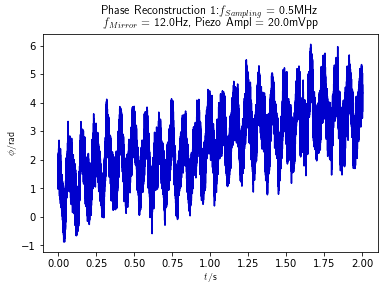

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(t_axis, phases_tol, color = 'mediumblue')
ax.set_ylabel(r'$\phi$/rad', useTex = True)
ax.set_xlabel(r'$t$/s', useTex = True)
plt.title(f"Phase Reconstruction 1:$f_{{Sampling}}$ = {SAMPLING_F/1e6}MHz\n$f_{{Mirror}}$ = {f}Hz, Piezo Ampl = {mVpp}mVpp", \
    useTex= True )

#### Checking for a genuine 12 Hz signal in this

Spectral Phase
Largest/peak frequency found at 0.00050 kHz


Text(0.5, 1.0, 'Periodogram of phase\nPeak at 0.000500 kHz')

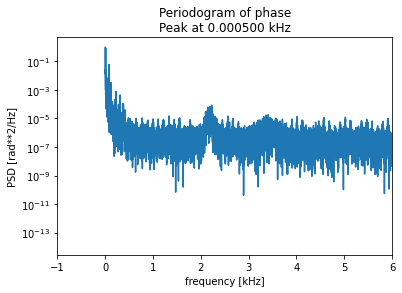

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=1)
periodogram_f, Qxx_den = periodogram(phases_tol, SAMPLING_F)
print('Spectral Phase')
print(f"Largest/peak frequency found at {periodogram_f[np.argmax(Qxx_den)]/1e3:.5f} kHz")
ax.semilogy(periodogram_f[1:]/1e3, Qxx_den[1:])
ax.set_ylim(min(Qxx_den[1:])/5, max(Qxx_den[1:])*5)
ax.set_xlim([-1, 6])
ax.set_xlabel('frequency [kHz]')
ax.set_ylabel('PSD [rad**2/Hz]')
ax.set_title(f'Periodogram of phase\nPeak at {periodogram_f[np.argmax(Qxx_den)]/1e3 :.6f} kHz')


In [8]:
def linear_root(x, m, r):
    return m*(x-r)

def drifting_sin(x, A, f, phi, m, c):
    return A * np.sin(2*pi*f*x + phi) + m*x+c

# drifting_sin_bounds = ((0, 0, -2*pi, -np.inf, -np.inf), 
#     (np.inf, np.inf, 2*pi, np.inf, np.inf)) 
drifting_sin_bounds = [[0, np.inf], [0, np.inf], [-2*pi, 2*pi], [-np.inf, np.inf], [-np.inf, np.inf]]
drifting_sin_bounds = np.asarray(EPstandard.transpose(drifting_sin_bounds)) 

In [11]:
popt, pcov = optimize.curve_fit(drifting_sin, t_axis, phases_tol, 
    p0= (2*0.05*mVpp, f, 0, 2, 0.5*(phases_tol[:100].max()+phases_tol[:100].min())), 
    bounds= drifting_sin_bounds)
fittings = EPstandard.easy_read_popt_pcov(popt, pcov)

B[0] = 0.90677(62)
B[1] = 12.00042(19)
B[2] = 1.9987(13)
B[3] = 1.38475(76)
B[4] = 1.15872(88)


Text(0.5, 1.0, "$f_{Mirror}$ = 12.0Hz, Piezo Ampl = 20.0mVpp,     $\\Delta$ = 0.00000Hz, \n(A, $f$, $\\phi_0$, $m$,         c) = ['0.90677(62)', '12.00042(19)', '1.9987(13)', '1.38475(76)', '1.15872(88)']")

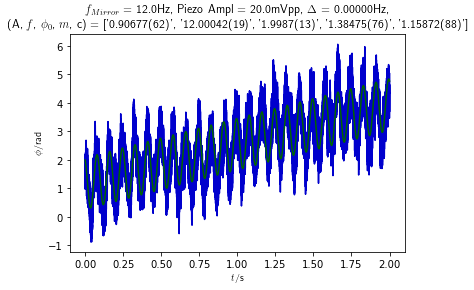

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(t_axis, phases_tol, color = 'mediumblue')
ax.plot(t_axis, drifting_sin(t_axis, *popt), color = 'darkgreen', markersize = 3)
ax.set_ylabel(r'$\phi$/rad', useTex = True)
ax.set_xlabel(r'$t$/s', useTex = True)
plt.title(f"$f_{{Mirror}}$ = {f}Hz, Piezo Ampl = {mVpp}mVpp, \
    $\Delta$ = {0:.5f}Hz, \n(A, $f$, $\phi_0$, $m$, \
        c) = {fittings}", useTex= True )

### Accumulate Method

```python
def phase_reconstruction_2(ph, phase_advance, get_deltas=False):
    """Phase reconstruction after arctan.
    
    Cumulatively sum the deviation of phase from expected phase.
    
    Inputs
    ----
    ph (iterable): phase generated from signal_to_phase functions; 
        optional parameter in sig_to_phase **must** be True
    tol (float): if change in phase exceeds this value, perform a wrap
    phase-advance (float): subtracts out advancement of wave from 0. 
        usually alr set to 0 as accounted for in `signal_to_phase`

    Outputs
    ----
    phase (np iterable): phase wrapped around 2pi accounted phase"""
    results = np.asarray([ph[0]])
    phase_advance %= 2*pi
    # for i in range(1, len(ph)):
    #     expected_phase = ph[i-1] + phase_advance
    #     # choose between the least difference (especially when expected 
    #     # phase > 2pi)
    #     delta = case1 if abs(case1:= ph[i]-expected_phase) < \
    #         abs(case2:= case1+2*pi) else case2
    #     results.append(delta)
    r = np.fromiter([case1 if abs(case1:= ph[i]-ph[i-1]-phase_advance) < \
            abs(case2:= case1+2*pi) else case2 for i in range(1,len(ph))], \
                dtype= np.float32, count= len(ph)-1)

    if get_deltas:
        return r
    results = np.append(results, r)
    return results
```


In [13]:
phases_accum = signal_to_phase(signal, N, 2*pi/N, phase_advancement_correction=False)
phases_accum = phase_reconstruction_2(phases_accum, 2*pi/N)
t_axis = np.arange(start= 0, 
    stop= (int(meta["Record Length"][0])-N) * meta['Sample Interval'][0], step= meta['Sample Interval'][0])


Text(0.5, 1.0, 'Phase Reconstruction 2:$f_{Sampling}$ = 0.5MHz\n$f_{Mirror}$ = 12.0Hz, Piezo Ampl = 20.0mVpp')

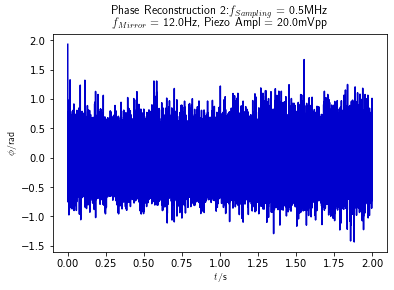

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(t_axis, phases_accum, color = 'mediumblue')
ax.set_ylabel(r'$\phi$/rad', useTex = True)
ax.set_xlabel(r'$t$/s', useTex = True)
plt.title(f"Phase Reconstruction 2:$f_{{Sampling}}$ = {SAMPLING_F/1e6}MHz\n$f_{{Mirror}}$ = {f}Hz, Piezo Ampl = {mVpp}mVpp", \
    useTex= True )

### Zooming in on tol method

In [15]:
zoom_start = int(0)
zoom_end = zoom_start + 100

Text(0.5, 1.0, 'Phase Reconstruction 1:$f_{Sampling}$ = 0.5MHz\n$f_{Mirror}$ = 12.0Hz, Piezo Ampl = 20.0mVpp')

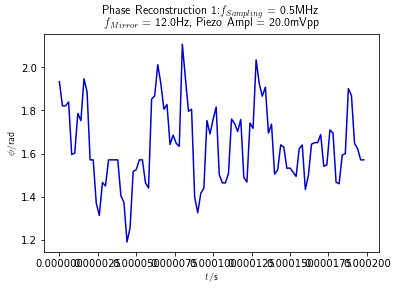

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(t_axis[zoom_start:zoom_end], phases_tol[zoom_start:zoom_end], color = 'mediumblue')
ax.set_ylabel(r'$\phi$/rad', useTex = True)
ax.set_xlabel(r'$t$/s', useTex = True)
plt.title(f"Phase Reconstruction 1:$f_{{Sampling}}$ = {SAMPLING_F/1e6}MHz\n$f_{{Mirror}}$ = {f}Hz, Piezo Ampl = {mVpp}mVpp", \
    useTex= True )

Text(0.5, 1.0, 'Phase Reconstruction 1:$f_{Sampling}$ = 0.5MHz\n$f_{Mirror}$ = 12.0Hz, Piezo Ampl = 20.0mVpp')

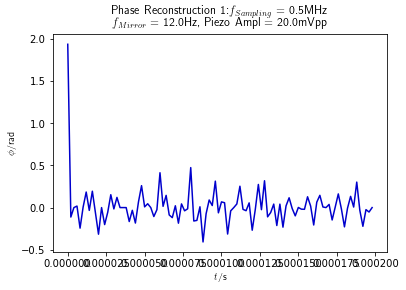

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(t_axis[zoom_start:zoom_end], phases_accum[zoom_start:zoom_end], color = 'mediumblue')
ax.set_ylabel(r'$\phi$/rad', useTex = True)
ax.set_xlabel(r'$t$/s', useTex = True)
plt.title(f"Phase Reconstruction 2:$f_{{Sampling}}$ = {SAMPLING_F/1e6}MHz\n$f_{{Mirror}}$ = {f}Hz, Piezo Ampl = {mVpp}mVpp", \
    useTex= True )

### Debugging the accum vs tol method

In [ ]:
def phase_reconstruction_debug(ph, tol, phase_advance= 0, debug= (True, 0, 0)):
    if tol > 2*pi: # this function is redundant when tolerance cannot be achieved
        return np.asarray(ph) if not isinstance(ph, np.ndarray) else ph

    r = [ph[0]]
    mod_twopi = 0
    phase_advance %= 2*pi
    for i in range(1, len(ph)):
        if ph[i] - ph[i-1] > tol:
            mod_twopi -= 1
        elif ph[i] - ph[i-1] < -tol:
            mod_twopi += 1
        r.append(ph[i] + 2 * pi * mod_twopi - phase_advance)
        if debug[0] and debug[1] <= i <= debug[2]:
            print() 
    
    r = np.asarray(r) # faster to append a Py list, convert to np
    return r

In [ ]:
def phase_reconstruction_2_debug(ph, phase_advance, get_deltas=False, debug= (True, 0, 100)):
    results = np.asarray([ph[0]])
    phase_advance %= 2*pi
    for i in range(1, len(ph)):
        expected_phase = ph[i-1] + phase_advance
        # choose between the least difference (especially when expected 
        # phase > 2pi)
        delta = case1 if abs(case1:= ph[i]-expected_phase) < \
            abs(case2:= case1+2*pi) else case2
        if debug[0] and debug[1] <= i <= debug[2]:
            print() 
        results.append(delta)
    # r = np.fromiter([case1 if abs(case1:= ph[i]-ph[i-1]-phase_advance) < \
    #         abs(case2:= case1+2*pi) else case2 for i in range(1,len(ph))], \
    #             dtype= np.float32, count= len(ph)-1)

    if get_deltas:
        return results
    results = np.append(results, results)
    return results